In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [35]:
target_column = 'default'

In [36]:
data = pd.read_csv('zbiór_15.csv')
data.head()

,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
0,117,214,6201,8993,112709.98,0.00,0.0,0.0,0.00,0.00,...,0.950530,0.950530,0.052044,0.000000,0.000000,0.000000,0.049470,0.049470,0.950530,1
1,117,214,4110,2607,2369051.57,5063.80,0.0,0.0,5063.80,5063.80,...,0.264511,0.271964,2.780566,0.000000,0.444723,0.444723,0.735489,0.708082,0.262935,1
2,117,215,7022,5868,71925.97,0.00,0.0,0.0,0.00,0.00,...,0.944960,0.944960,0.058246,0.055040,0.000000,0.000000,0.055040,0.055040,0.944960,1
3,117,214,6920,1668,12247.82,0.00,0.0,0.0,0.00,0.00,...,0.774826,0.774826,0.290612,0.225174,0.000000,0.000000,0.225174,0.225174,0.774826,1
4,117,214,6619,1994,614984.31,131077.01,0.0,0.0,118777.01,118777.01,...,0.394975,1.251990,1.531805,0.206732,0.371039,0.371039,0.605025,-0.079497,0.231091,1


In [37]:
data.describe()

e:\conda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
count,3000.0,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,...,3000.000000,2957.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,117.0,200.979667,5344.899000,4043.084000,7.736907e+06,5.146257e+06,4.285282e+04,4.747901e+03,1.131901e+06,1.011080e+06,...,5.092878,NaN,14.869922,1.892967,1.938928,1.940652,14.663446,9.615697,-6.743099,0.053000
std,0.0,51.816209,1962.118082,2794.093839,9.986779e+07,8.898365e+07,9.220774e+05,9.643449e+04,5.362261e+06,5.018179e+06,...,119.399309,NaN,392.698022,58.012314,59.058917,59.058880,497.022096,373.166334,681.316755,0.224071
min,117.0,0.000000,0.000000,1204.000000,0.000000e+00,0.000000e+00,-5.800000e-01,0.000000e+00,0.000000e+00,-8.739250e+03,...,-939.811838,-inf,-1.351786,-16.265592,-17.825569,-17.825569,-180.575028,-1844.269400,-32062.387100,0.000000
25%,117.0,214.000000,4321.000000,1805.750000,8.797910e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.348431,0.412853,0.074446,0.000000,0.000000,0.000000,0.069078,-0.066635,0.081244,0.000000
50%,117.0,214.000000,4941.000000,3009.000000,5.992333e+05,2.230695e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.658558,0.794606,0.447030,0.000000,0.000000,0.000000,0.309920,0.135711,0.508948,0.000000
75%,117.0,215.000000,6920.000000,5636.750000,2.709980e+06,5.616736e+05,0.000000e+00,0.000000e+00,1.350023e+05,1.024320e+05,...,0.904009,1.063178,1.537708,0.190159,0.102220,0.103234,0.612969,0.490105,0.857255,0.000000
max,117.0,338.000000,9609.000000,16617.000000,4.532282e+09,4.531929e+09,4.860000e+07,3.933141e+06,1.202187e+08,1.191571e+08,...,4300.000000,inf,20866.570800,2638.471300,2557.170400,2557.170400,24378.434200,16593.611300,15211.326300,1.000000


In [38]:
list(data.columns)

['szczegolnaFormaPrawna_Symbol',
 'formaWlasnosci_Symbol',
 'pkdKod',
 'wsk_liczba_dni_istnienia',
 'Aktywa',
 'Aktywa_trwale',
 'Wartosci_niematerialne_prawne',
 'Wartosc_firmy',
 'Rzeczowe_aktywa_trwale',
 'Srodki_trwale',
 'Naleznosci_dlugoterminowe',
 'Inwestycje_dlugoterminowe',
 'Rozliczenia_miedzyokresowe_dlugie',
 'Aktywa_obrotowe',
 'Zapasy',
 'Naleznosci_krotkoterminowe',
 'Naleznosci_dostaw_uslug_12m_powiazane',
 'Naleznosci_dostaw_uslug_pow12m_powiazane',
 'Naleznosci_dostaw_uslug_12m_kapitale',
 'Naleznosci_dostaw_uslug_pow12m_kapitale',
 'Naleznosci_dostaw_uslug_12m_pozostale',
 'Naleznosci_dostaw_uslug_pow12m_pozostale',
 'Naleznosci_dostaw_uslug_pozostale_sadowe',
 'Inwestycje_krotkoterminowe',
 'Srodki_pieniezne',
 'Rozliczenia_miedzyokresowe_krotkie',
 'Kapital_wlasny',
 'Kapital_podstawowy',
 'Kapital_zapasowy',
 'Zysk_netto',
 'Zobowiazania_rezerwy',
 'Rezerwy_na_zobowiazania',
 'Rezerwa_z_tytulu_odroczonego_podatku_dochodowego',
 'Rezerwa_na_swiadczenia_emerytalne'

In [39]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['schemat_wsk_bilans', 'schemat_wsk_rzis'], dtype='object')


In [40]:
data[categorical_features].head(10)

,schemat_wsk_bilans,schemat_wsk_rzis
0,SFJIN,SFJIN
1,SFJMA,SFJMA
2,SFJMI,SFJMI
3,SFJMI,SFJMI
4,SFJMA,SFJMA
5,SFJIN,SFJIN
6,SFJIN,SFJIN
7,SFJMA,SFJMA
8,SFJIN,SFJIN
9,SFJIN,SFJIN


## One hot encode categorical features

In [41]:
one_hot_encoded = pd.get_dummies(data[categorical_features])
data = pd.concat([data, one_hot_encoded], axis=1)
data = data.drop(categorical_features, axis=1)

## Replace NaNs with median

In [42]:
data = data.fillna(data.median())
data.describe()

e:\conda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
count,3000.0,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,117.0,200.979667,5344.899000,4043.084000,7.736907e+06,5.146257e+06,4.285282e+04,4.747901e+03,1.131901e+06,1.011080e+06,...,5.092878,NaN,14.869922,1.892967,1.938928,1.940652,14.663446,9.615697,-6.743099,0.053000
std,0.0,51.816209,1962.118082,2794.093839,9.986779e+07,8.898365e+07,9.220774e+05,9.643449e+04,5.362261e+06,5.018179e+06,...,119.399309,NaN,392.698022,58.012314,59.058917,59.058880,497.022096,373.166334,681.316755,0.224071
min,117.0,0.000000,0.000000,1204.000000,0.000000e+00,0.000000e+00,-5.800000e-01,0.000000e+00,0.000000e+00,-8.739250e+03,...,-939.811838,-inf,-1.351786,-16.265592,-17.825569,-17.825569,-180.575028,-1844.269400,-32062.387100,0.000000
25%,117.0,214.000000,4321.000000,1805.750000,8.797910e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.348431,0.419260,0.074446,0.000000,0.000000,0.000000,0.069078,-0.066635,0.081244,0.000000
50%,117.0,214.000000,4941.000000,3009.000000,5.992333e+05,2.230695e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.658558,0.794606,0.447030,0.000000,0.000000,0.000000,0.309920,0.135711,0.508948,0.000000
75%,117.0,215.000000,6920.000000,5636.750000,2.709980e+06,5.616736e+05,0.000000e+00,0.000000e+00,1.350023e+05,1.024320e+05,...,0.904009,1.050612,1.537708,0.190159,0.102220,0.103234,0.612969,0.490105,0.857255,0.000000
max,117.0,338.000000,9609.000000,16617.000000,4.532282e+09,4.531929e+09,4.860000e+07,3.933141e+06,1.202187e+08,1.191571e+08,...,4300.000000,inf,20866.570800,2638.471300,2557.170400,2557.170400,24378.434200,16593.611300,15211.326300,1.000000


# Replace inf and -inf with max and min value from column

In [43]:
missing_columns = ['wsk_plynnosc_biez_1', 'wsk_struktura_kap_wlasnego_s_2', 'wsk_kapital_do_aktywa']

# Replace 'inf' with maximum value and '-inf' with minimum value in each column
for column in missing_columns:
    max_value = data[column].replace([np.inf, -np.inf], np.nan).max()
    min_value = data[column].replace([np.inf, -np.inf], np.nan).min()
    data[column].replace([np.inf, -np.inf], np.nan, inplace=True)
    data[column].fillna(max_value, inplace=True)  # Replace 'inf' with max
    data[column].replace(-np.inf, min_value, inplace=True)  # Replace '-inf' with min

In [44]:
def calculate_woe_iv(data, variable, target):
    # Create bins for numerical variables
    if pd.api.types.is_numeric_dtype(data[variable]):
        bins_variable = variable + '_bins'
        data[bins_variable] = pd.qcut(data[variable], q=10, duplicates='drop')

        # Create a table with counts of each category and the count of target = 1
        grouped = data.groupby(bins_variable)[target].agg(['count', 'sum'])
        grouped = grouped.rename(columns={'count': 'total', 'sum': 'events'})
    else:
        # Create a table with counts of each category and the count of target = 1 for non-numeric variables
        grouped = data.groupby(variable)[target].agg(['count', 'sum'])
        grouped = grouped.rename(columns={'count': 'total', 'sum': 'events'})

    # Calculate WOE and IV
    grouped['non_events'] = grouped['total'] - grouped['events']

    # Add a small constant to prevent divide by zero
    eps = 1e-8
    grouped['event_rate'] = (grouped['events'] + eps) / (grouped['events'].sum() + eps)
    grouped['non_event_rate'] = (grouped['non_events'] + eps) / (grouped['non_events'].sum() + eps)

    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    # Sum up the IV values for each category
    iv = grouped['iv'].sum()

    return grouped, iv

In [45]:
# Calculate WOE and IV for each variable
import copy

data_copied = copy.deepcopy(data)

woe_iv_results = []
for column in data.columns:
    if column != target_column:
        grouped_data, iv = calculate_woe_iv(data_copied, column, target_column)
        woe_iv_results.append({'Variable': column, 'IV': iv})

# Sort the results by IV in descending order
woe_iv_results = sorted(woe_iv_results, key=lambda x: x['IV'])

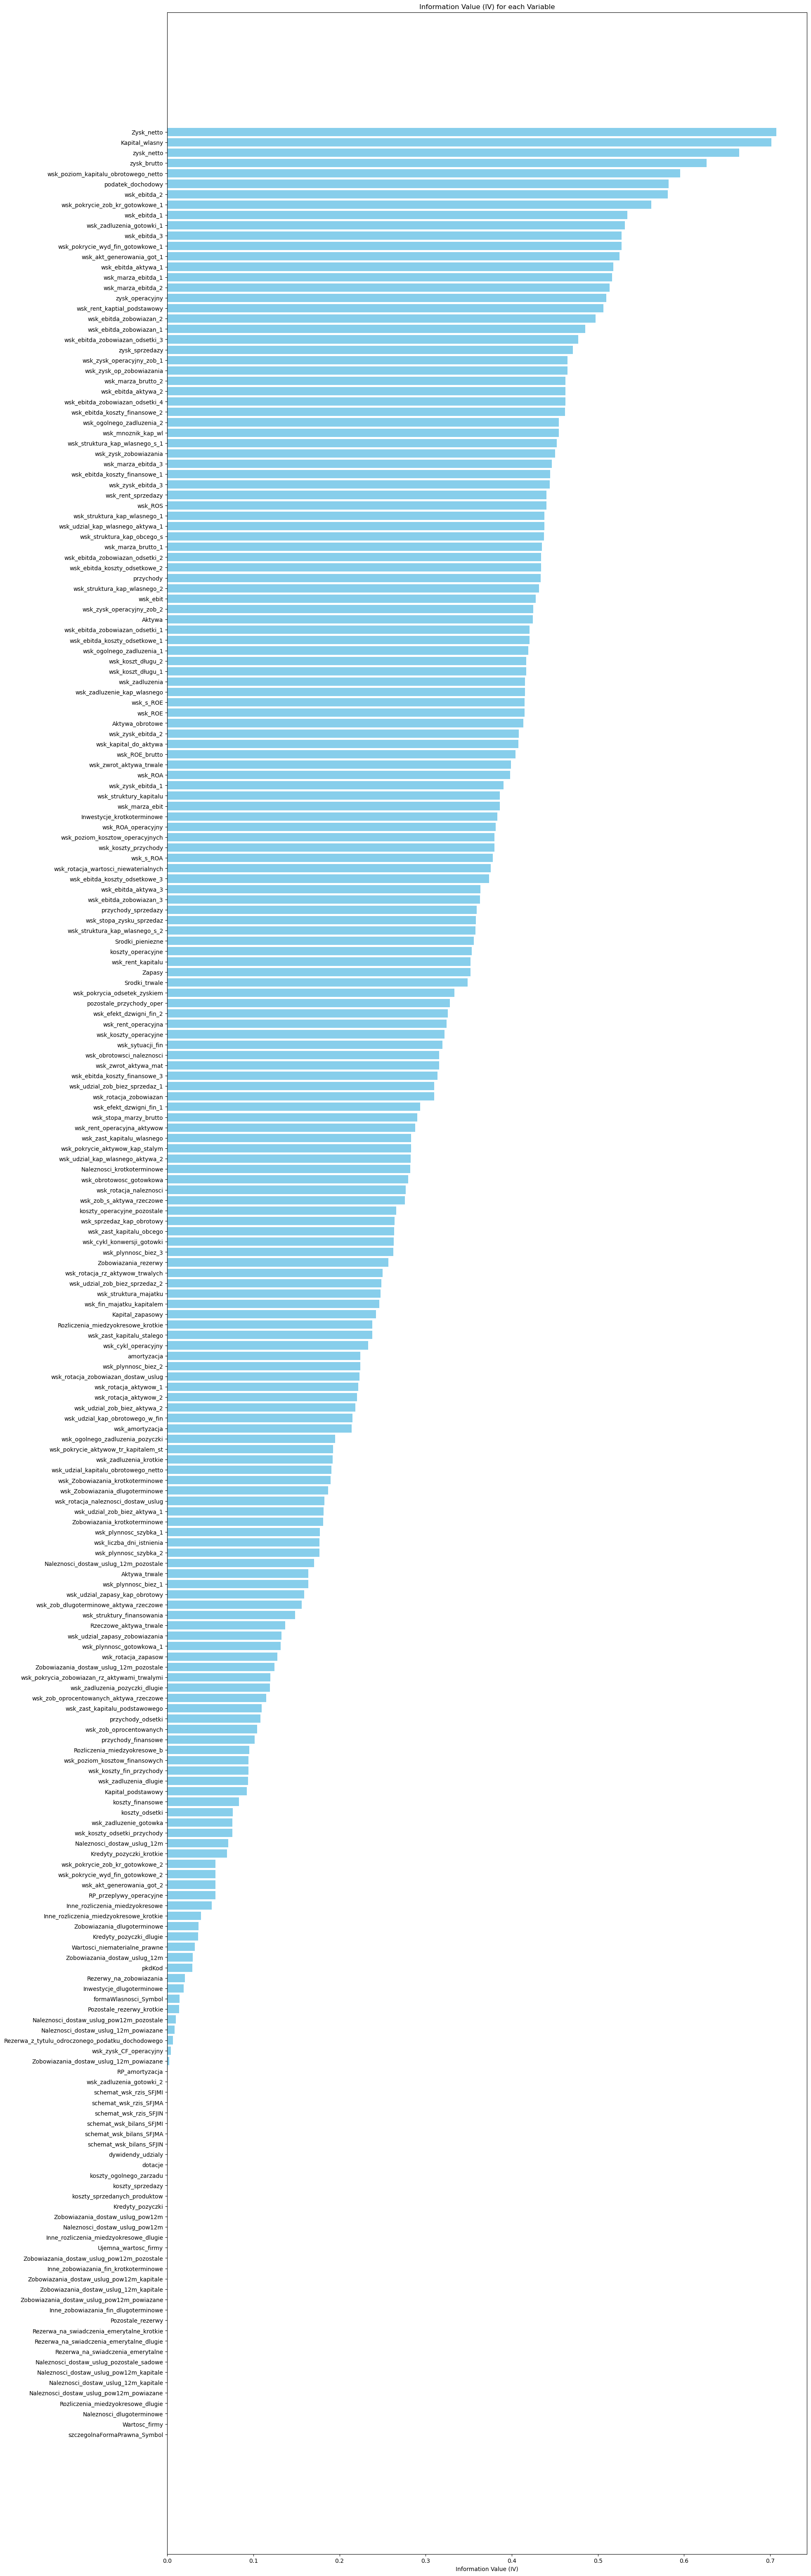

In [46]:
variables = [result['Variable'] for result in woe_iv_results]
iv_values = [result['IV'] for result in woe_iv_results]

# Create a bar plot
plt.figure(figsize=(20, 80))
plt.barh(variables, iv_values, color='skyblue')
plt.xlabel('Information Value (IV)')
plt.title('Information Value (IV) for each Variable')
plt.show()

## Drop low IV columns (albo od 0.1 albo od 0.3 możemy wywalać)

In [47]:
print("Number of colums before: " + str(len(data.columns)))
low_iv_columns = [result['Variable'] for result in woe_iv_results if result['IV'] < 0.3]
data.drop(low_iv_columns, axis=1, inplace=True)
print("Number of colums after: " + str(len(data.columns)))

Number of colums before: 224
Number of colums after: 95


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

features = data.drop(target_column, axis=1)  
target = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.945


In [49]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9416666666666667
